<a href="https://colab.research.google.com/github/varshavmg/Predictive-Maintainance/blob/main/PdM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/tmp/ipython-input-3834037525.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best Score for Random Forest: 0.9821428571428571
[LightGBM] [Info] Number of positive: 246, number of negative: 6754
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035143 -> initscore=-3.312559
[LightGBM] [Info] Start training from score -3.312559


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:12:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Summary of Evaluation Metrics for All Models:
                 Model Accuracy Precision  Recall F1 Score ROC-AUC
0  Logistic Regression   0.9740    0.7273  0.2581   0.3810  0.8929
1        Decision Tree   0.9800    0.6701  0.6989   0.6842  0.8440
2        Random Forest   0.9870    0.8971  0.6559   0.7578  0.9522
3    Gradient Boosting   0.9857    0.8571  0.6452   0.7362  0.9691
4                  SVM   0.9773    0.9032  0.3011   0.4516  0.9569
5       Neural Network   0.9817    0.8065  0.5376   0.6452  0.9692
6             LightGBM   0.9843    0.8594  0.5914   0.7006  0.9728
7              XGBoost   0.9843    0.8382  0.6129   0.7081  0.9720

Best Model based on F1 Score:
Model        Random Forest
Accuracy            0.9870
Precision           0.8971
Recall              0.6559
F1 Score            0.7578
ROC-AUC             0.9522
Name: 2, dtype: object


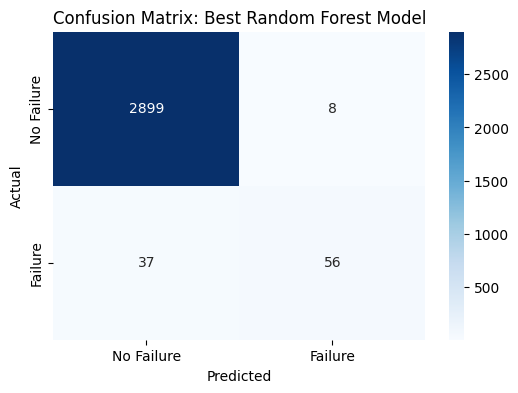

Predictions from Loaded Model: [0 0 0 ... 0 0 0]
Cross-validation scores: [0.973  0.973  0.5675 0.973  0.9805]
Mean CV Accuracy: 0.8934


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import lightgbm as lgb
import xgboost as xgb

path = '/predictive_maintenance.csv'
data = pd.read_csv(path)

X = data[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]
y = data['Target']

X.fillna(X.mean(), inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

joblib.dump(scaler, "scaler.pkl")

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Neural Network": MLPClassifier(max_iter=500, random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss') # Added eval_metric to avoid warning
}

param_grid_rf = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=5,  # 5-fold cross-validation
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)
grid_search_rf.fit(X_train, y_train)
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
print("Best Score for Random Forest:", grid_search_rf.best_score_)

best_rf_model = grid_search_rf.best_estimator_

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    # Predict on the test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="binary")
    recall = recall_score(y_test, y_pred, average="binary")
    f1 = f1_score(y_test, y_pred, average="binary")
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    results.append({
        "Model": name,
        "Accuracy": f"{accuracy:.4f}",
        "Precision": f"{precision:.4f}",
        "Recall": f"{recall:.4f}",
        "F1 Score": f"{f1:.4f}",
        "ROC-AUC": f"{roc_auc:.4f}" if roc_auc is not None else "N/A"
    })

results_df = pd.DataFrame(results)
print("Summary of Evaluation Metrics for All Models:")
print(results_df)

best_model = results_df.loc[results_df["F1 Score"].astype(float).idxmax()]
print("\nBest Model based on F1 Score:")
print(best_model)
cm = confusion_matrix(y_test, best_rf_model.predict(X_test))
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Failure", "Failure"], yticklabels=["No Failure", "Failure"])
plt.title('Confusion Matrix: Best Random Forest Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

joblib.dump(best_rf_model, "best_random_forest_model.pkl")

loaded_model = joblib.load("best_random_forest_model.pkl")
new_predictions = loaded_model.predict(X_test)
print("Predictions from Loaded Model:", new_predictions)

cv_scores = cross_val_score(best_rf_model, X_scaled, y, cv=5, scoring="accuracy")
print("Cross-validation scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

In [1]:
!pip install lightgbm xgboost